In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

In [ ]:
transform = transforms.Compose([
        transforms.Resize((14, 14)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x > 0.5).float())
    ])

train_dataset = torchvision.datasets.MNIST(root='./data',
                                               train=True,
                                               download=True,
                                               transform=transform)

digit_counts = {i:0 for i in range(10)}
filtered_indices = []

val_digit_counts = {i:0 for i in range(10)}
val_filtered_indices = []

for idx, (img, label) in enumerate(train_dataset):
    if digit_counts.get(label, 0) < 1000:
        digit_counts[label] += 1
        filtered_indices.append(idx)
    elif val_digit_counts.get(label, 0) < 100:
        val_digit_counts[label] += 1
        val_filtered_indices.append(idx)

train_subset = torch.utils.data.Subset(train_dataset, filtered_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_filtered_indices)

train_dataloader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=32, shuffle=True)

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(196, 128),
            nn.Tanh(),
            nn.Linear(128, 16)
        )

        self.decoder = nn.Sequential(
            nn.Linear(8, 128),
            nn.Tanh(),
            nn.Linear(128, 196),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = x[:,:8], x[:,8:]
        x = self.reparameterize(mu, logvar)
        x = self.decoder(x)
        return x, mu, logvar

In [ ]:
def loss_function(x_hat, x, mu, logvar):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    kl_div_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss, kl_div_loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
recon_losses_epoch = []
kl_losses_epoch = []

recon_losses = []
kl_losses = []

val_log_likelihood = []

num_updates = 0
for epoch in range(50):
    epoch_recon_losses = []
    epoch_kl_losses = []

    for batch_idx, (data, _) in enumerate(train_dataloader):
        model.train()
        data = data.view(data.size(0), -1).to(device)

        recon_batch, mu, log_var = model(data)

        reconstruction_loss, kl_loss = loss_function(recon_batch, data, mu, log_var)
        loss = reconstruction_loss + kl_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        recon_losses.append(reconstruction_loss.item())
        kl_losses.append(kl_loss.item())

        epoch_recon_losses.append(reconstruction_loss.item())
        epoch_kl_losses.append(kl_loss.item())

        num_updates += 1

        if num_updates % 100 == 0:
            model.eval()
            with torch.no_grad():
                num_samples = 0
                log_likelihood = 0
                for val_data, _ in val_dataloader:
                    val_data = val_data.view(val_data.size(0), -1).to(device)

                    num_samples += len(val_data)

                    val_recon_batch, val_mu, val_logvar = model(val_data)

                    val_reconstruction_loss, val_kl_loss = loss_function(val_recon_batch, val_data, val_mu, val_logvar)

                    log_likelihood += -1 * val_reconstruction_loss.item()

                log_likelihood /= num_samples
                val_log_likelihood.append(log_likelihood)


    # Average losses for the epoch
    recon_losses_epoch.append(np.mean(epoch_recon_losses))
    kl_losses_epoch.append(np.mean(epoch_kl_losses))

    print(f'Epoch {epoch+1}: Recon Loss = {recon_losses[-1]:.4f}, KL Loss = {kl_losses[-1]:.4f}')

Epoch 1: Recon Loss = 741.9642, KL Loss = 69.7163
Epoch 2: Recon Loss = 595.2776, KL Loss = 89.2712
Epoch 3: Recon Loss = 578.8101, KL Loss = 105.5608
Epoch 4: Recon Loss = 524.9893, KL Loss = 100.8561
Epoch 5: Recon Loss = 464.4569, KL Loss = 114.9253
Epoch 6: Recon Loss = 469.5769, KL Loss = 118.0532
Epoch 7: Recon Loss = 380.5588, KL Loss = 101.6418
Epoch 8: Recon Loss = 463.8198, KL Loss = 119.6758
Epoch 9: Recon Loss = 400.7105, KL Loss = 123.9497
Epoch 10: Recon Loss = 503.0702, KL Loss = 114.5331
Epoch 11: Recon Loss = 447.5592, KL Loss = 130.4702
Epoch 12: Recon Loss = 397.0023, KL Loss = 131.1104
Epoch 13: Recon Loss = 465.2796, KL Loss = 124.3563
Epoch 14: Recon Loss = 421.7451, KL Loss = 128.0717
Epoch 15: Recon Loss = 448.1707, KL Loss = 132.8497
Epoch 16: Recon Loss = 361.0861, KL Loss = 118.5875
Epoch 17: Recon Loss = 427.9099, KL Loss = 135.0705
Epoch 18: Recon Loss = 383.2762, KL Loss = 129.8231
Epoch 19: Recon Loss = 435.8402, KL Loss = 133.9319
Epoch 20: Recon Loss = 

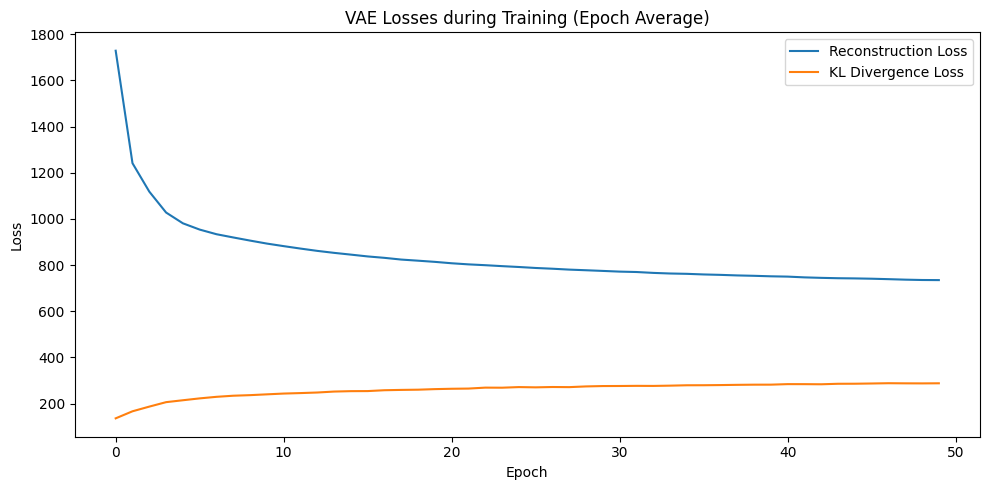

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(recon_losses_epoch, label='Reconstruction Loss')
plt.plot(kl_losses_epoch, label='KL Divergence Loss')
plt.title('VAE Losses during Training (Epoch Average)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

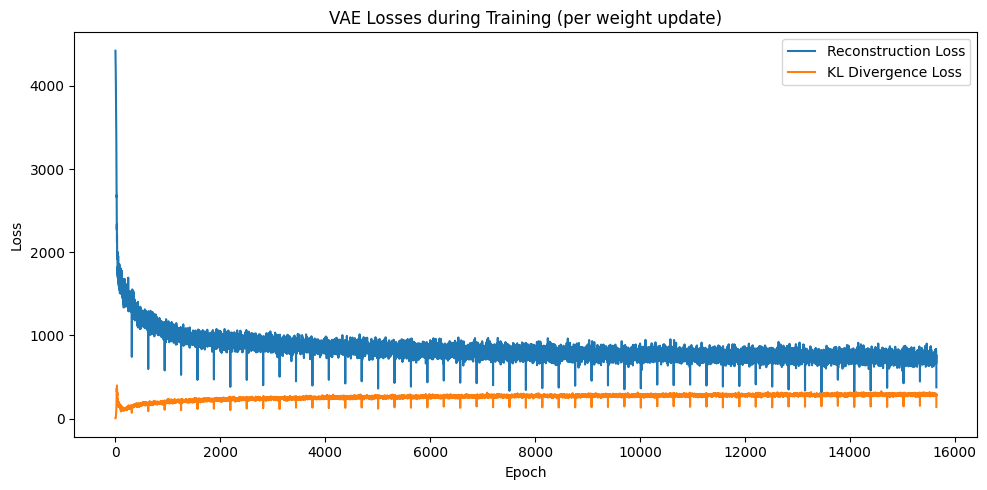

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(kl_losses, label='KL Divergence Loss')
plt.title('VAE Losses during Training (per weight update)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# len(val_log_likelihood)
len(recon_losses)

15650

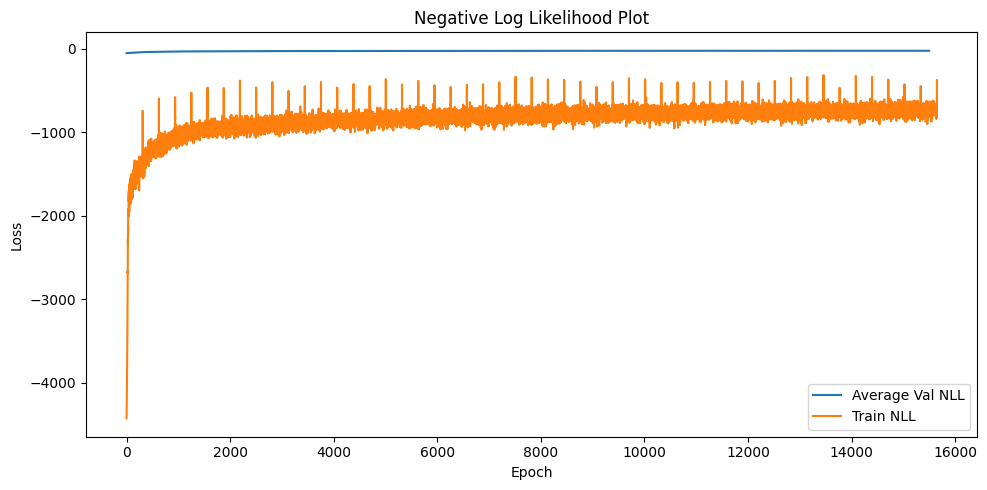

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, len(recon_losses)-100, 100), val_log_likelihood, label='Average Val NLL')
plt.plot(np.arange(0, len(recon_losses), 1), [-1*x for x in recon_losses], label='Train NLL')
plt.title('Negative Log Likelihood Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

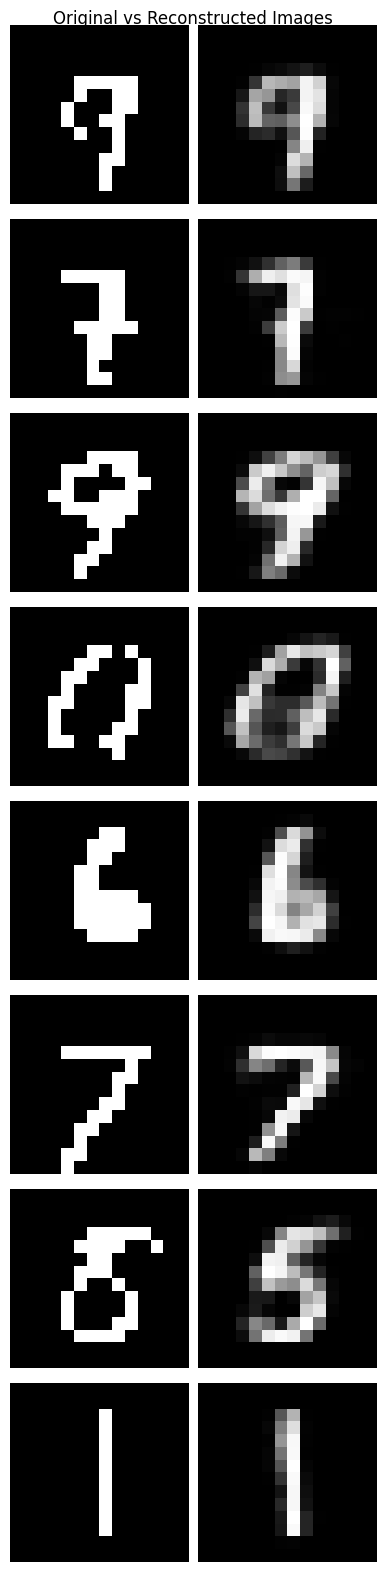

In [ ]:
model.eval()
with torch.no_grad():
    # Get first batch
    data, _ = next(iter(train_dataloader))
    data = data.view(data.size(0), -1).to(device)

    # Reconstruct
    recon_batch, _, _ = model(data)

    # Plot original and reconstructed
    fig, axs = plt.subplots(8, 2, figsize=(4, 16))
    for i in range(8):
        # Original images
        axs[i, 0].imshow(data[i].view(14, 14).cpu().numpy(), cmap='gray')
        axs[i, 0].axis('off')

        # Reconstructed images
        axs[i, 1].imshow(recon_batch[i].view(14, 14).cpu().numpy(), cmap='gray')
        axs[i, 1].axis('off')

    plt.suptitle('Original vs Reconstructed Images')
    plt.tight_layout()
    plt.show()

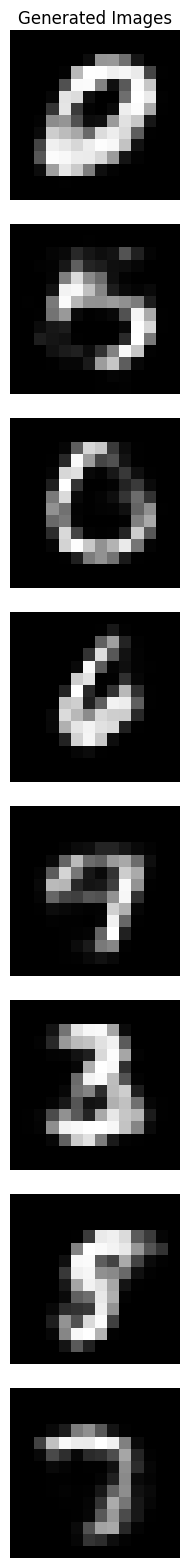

In [ ]:
model.eval()
with torch.no_grad():
    # Sample from standard Gaussian
    z = torch.randn(8, 8).to(device)

    # Generate images
    generated_images = model.decoder(z)

    # Plot generated images
    fig, axs = plt.subplots(8, 1, figsize=(2, 16))

    for i in range(8):
        axs[i].imshow(generated_images[i].view(14, 14).cpu().numpy(), cmap='gray')
        axs[i].axis('off')

    plt.suptitle('Generated Images')
    plt.tight_layout()
    plt.show()
